In [2]:
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

In [3]:
sheet_list = ["6-periods (1)", "6-periods (2)", "12-periods (1)", "12-periods (2)", 
              "24-periods (1)", "24-periods (2)", "52-periods (1)", "52-periods (2)", 
              "104-periods (1)", "104-periods (2)"]

data_dict = {}
for sheet_name in sheet_list:
    data_dict[sheet_name] = pd.read_excel("ULSP-instancesR.xlsx", sheet_name=sheet_name)

In [4]:
def gurobi_solve(df):
    demand_forecast = [0] + list(df['Demand Forecast'])
    setup_cost = [0] + list(df['Setup Cost'])
    production_cost = [0] + list(df['Production cost'])
    holding_cost = [0] + list(df['Holding cost'])

    model = gp.Model("Uncapacitated Lot-Sizing Problem")

    T = len(demand_forecast)
    M = 1e9

    y = model.addVars(T, vtype=GRB.BINARY, name="y")
    x = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="x")
    S = model.addVars(T, vtype=GRB.CONTINUOUS, lb=0, name="S")

    model.setObjective(
        gp.quicksum(
            production_cost[t] * x[t] + setup_cost[t] * y[t] + holding_cost[t] * S[t] for t in range(T)
        ), GRB.MINIMIZE)

    model.addConstr(S[0] == 0, name="no initial inventory")
#     model.addConstr(S[T-1] == 0, name="no final inventory")

    for t in range(1, T):
        model.addConstr(S[t-1] + x[t] == demand_forecast[t] + S[t])
        model.addConstr(x[t] <= M * y[t], name=f"Setup_Link_{t}")

    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        print("\nOptimal Solution:")
        for t in range(T):
            print(f"Period {t}: y: {int(y[t].x)}, \tDemand: {demand_forecast[t]}, \t x: {x[t].x:.2f},\t S: {S[t].x:.2f},\t")
        print(f"\nTotal Cost: {model.objVal}")
    else:
        print("No optimal solution found.")
    
    return model.objVal, [x[t].x for t in range(T)], [S[t].x for t in range(T)]

In [5]:
def Wagner_Whitin(df):
    T = len(df['Demand Forecast'])  
    demand_forecast = df['Demand Forecast']
    setup_cost = df['Setup Cost']
    production_cost = df['Production cost']
    holding_cost = list(df['Holding cost'])
    
    cost_matrix = np.ones(shape=[T, T]) * np.inf
    
    for prod in range(T):
        for rec in range(prod, T):
            cost = demand_forecast[rec] * (production_cost[prod] + np.sum(holding_cost[prod:rec])) + setup_cost[prod]
            cost_matrix[prod, rec] = cost
    
#     print(cost_matrix)
    
    total_cost = 0
    production_plan = [0] * T
    for i in range(T):
        row = cost_matrix[:, i]
        total_cost += min(row)
        idx = list(row).index(min(row))
        
        if production_plan[idx] == 0:
            cost_matrix[idx, :] -= setup_cost[idx]
        
        production_plan[idx] += demand_forecast[i]
    
    return total_cost, production_plan

Wagner_Whitin(data_dict[sheet])

NameError: name 'sheet' is not defined

In [6]:
sheet = '6-periods (2)'
gurobi_solve(data_dict[sheet])

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-04
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13 rows, 21 columns and 31 nonzeros
Model fingerprint: 0x91482b86
Variable types: 14 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+02, 9e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 4 rows and 7 columns
Presolve time: 0.00s
Presolved: 9 rows, 14 columns, 22 nonzeros
Variable types: 9 continuous, 5 integer (5 binary)
Found heuristic solution: objective 105079.00000

Root relaxation: objective 1.022900e+

(102290.010620512,
 [0.0, 573.0, 3808.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 3275.0, 2379.0, 1509.0, 691.0, 0.0])

In [7]:
Wagner_Whitin(data_dict[sheet])

(105079.0, [573, 3808, 0, 0, 0, 0])

In [8]:
results_gurobi = {}
results_ww = {}

for sheet_name in sheet_list:
    results_gurobi[sheet_name] = gurobi_solve(data_dict[sheet_name])
    results_ww[sheet_name] = Wagner_Whitin(data_dict[sheet_name])
    

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13 rows, 21 columns and 31 nonzeros
Model fingerprint: 0xbff51b81
Variable types: 14 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [3e+00, 4e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+02, 6e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 5 rows and 8 columns
Presolve time: 0.00s
Presolved: 8 rows, 13 columns, 20 nonzeros
Variable types: 8 continuous, 5 integer (5 binary)
Found heuristic solution: objective 54875.000000

Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds 


CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 49 rows, 75 columns and 121 nonzeros
Model fingerprint: 0x341d2278
Variable types: 50 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [2e+00, 6e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+01, 9e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 78650.000000
Presolve removed 9 rows and 12 columns
Presolve time: 0.00s
Presolved: 40 rows, 63 columns, 102 nonzeros
Variable types: 40 continuous, 23 integer (23 binary)

Root relaxation: objective 7.289467e+04, 39 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 105 rows, 159 columns and 261 nonzeros
Model fingerprint: 0x65e3ce2f
Variable types: 106 continuous, 53 integer (53 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 333000.00000
Presolve removed 11 rows and 14 columns
Presolve time: 0.00s
Presolved: 94 rows, 145 columns, 238 nonzeros
Variable types: 94 continuous, 51 integer (51 binary)

Root relaxation: objective 1.253661e+05, 93 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current 

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11800H @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 209 rows, 315 columns and 521 nonzeros
Model fingerprint: 0xfcec5d3a
Variable types: 210 continuous, 105 integer (105 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+09]
  Objective range  [1e+00, 5e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 2541038.0000
Presolve removed 15 rows and 18 columns
Presolve time: 0.00s
Presolved: 194 rows, 297 columns, 490 nonzeros
Variable types: 194 continuous, 103 integer (103 binary)

Root relaxation: objective 3.953880e+05, 229 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    C

In [9]:
for sheet_name in sheet_list:
    if results_gurobi[sheet_name][1][1:] != results_ww[sheet_name][1]:
        print(sheet_name)
        print(results_gurobi[sheet_name][1][1:], results_gurobi[sheet_name][0])
        print(results_ww[sheet_name][1], results_ww[sheet_name][0])
        print()

12-periods (1)
[875.0, 17.0, 325.0, 0.0, 477.0, 817.0, 182.0, 445.0, 487.0, 0.0, 506.0, 863.0] 41269.007360744006
[892, 0, 325, 0, 477, 999, 0, 445, 487, 0, 506, 863] 55390.0

12-periods (2)
[623.0, 835.0, 71.0, 958.0, 319.0, 0.0, 689.0, 414.0, 372.0, 346.0, 0.0, 938.0] 40682.002270268
[623, 906, 0, 958, 319, 0, 689, 414, 372, 346, 0, 938] 44793.0

24-periods (1)
[660.0, 837.0, 164.0, 0.0, 857.0, 117.0, 73.0, 0.0, 100.0, 454.0, 924.0, 496.0, 703.0, 469.0, 706.0, 907.0, 321.0, 0.0, 192.0, 0.0, 0.0, 883.0, 783.0, 727.0] 73768.002595612
[660, 837, 164, 0, 857, 190, 0, 0, 100, 454, 924, 496, 703, 469, 706, 907, 321, 0, 192, 0, 0, 883, 783, 727] 78316.0

24-periods (2)
[349.0, 718.0, 1366.0, 0.0, 853.0, 0.0, 332.0, 0.0, 363.0, 0.0, 428.0, 414.0, 403.0, 643.0, 199.0, 330.0, 628.0, 585.0, 840.0, 665.0, 0.0, 1016.0, 0.0, 512.0] 82277.043811879
[1067, 0, 1366, 0, 1185, 0, 0, 0, 791, 0, 0, 414, 1245, 0, 330, 0, 628, 585, 2521, 0, 0, 0, 0, 512] 143403.0

52-periods (1)
[614.0, 612.0, 0.0, 271.0, 

6-periods (1) 54875.0


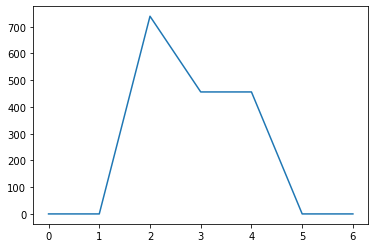

6-periods (2) 102290.010620512


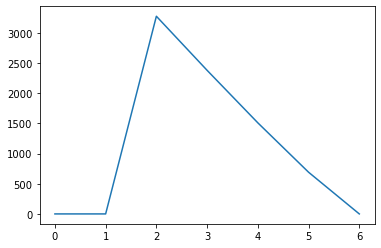

12-periods (1) 41269.007360744006


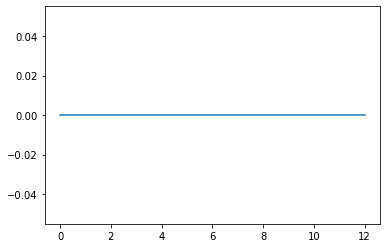

12-periods (2) 40682.002270268


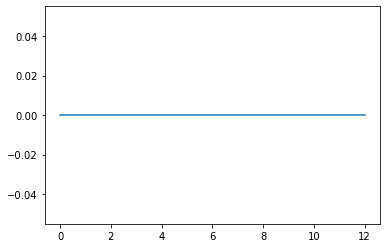

24-periods (1) 73768.002595612


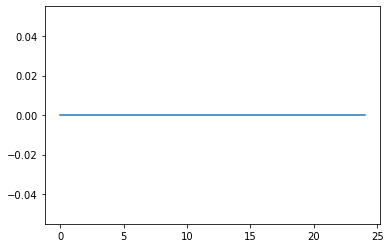

24-periods (2) 82277.043811879


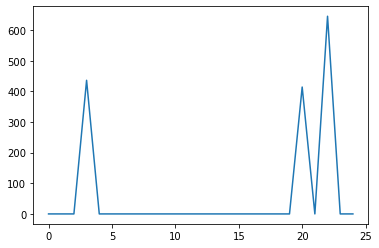

52-periods (1) 131421.073037636


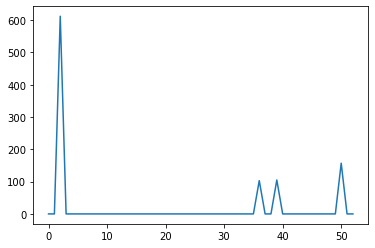

52-periods (2) 125366.07536983202


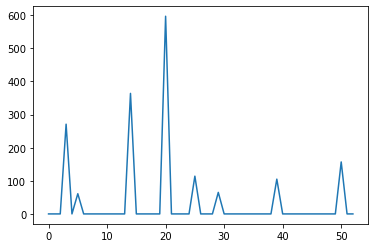

104-periods (1) 217843.117562731


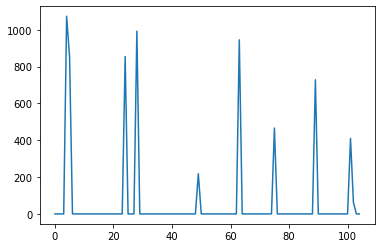

104-periods (2) 395387.980550857


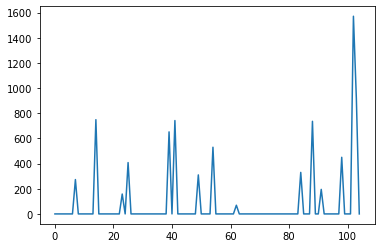

In [10]:
for sheet_name in sheet_list:
    print(sheet_name, results_gurobi[sheet_name][0])
    plt.plot(results_gurobi[sheet_name][2])
    plt.show()